# Kaggle Playground S4e1 - Predict Bank Customer Churn
## Links
- Competition: <https://www.kaggle.com/competitions/playground-series-s4e1/overview>
- Dataset used as base of the competition's dataset: <https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction>

## About dataset

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no) 

## Load dataset

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
import xgboost as xgb

/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv(os.path.join('datasets', 'train.csv'))
df_id = df['id']
df.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [5]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 13.9+ MB


No missing values

In [7]:
y = df['Exited']

In [8]:
type(y.value_counts())

pandas.core.series.Series

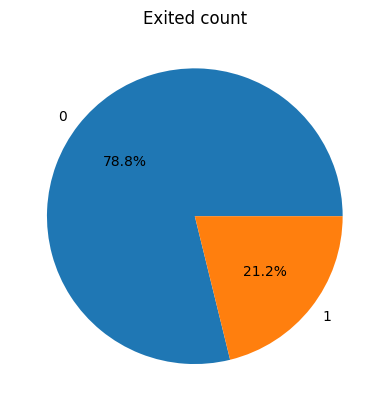

In [9]:
def plot_y(y: pd.Series):
    fig, ax = plt.subplots()
    ax.set_title('Exited count')
    y_value_counts = y.value_counts()
    y_index = y_value_counts.index
    y_values = y_value_counts.values
    ax.pie(y_values, labels=y_index, autopct='%1.1f%%')

plot_y(y)

Need class balacing.

In [10]:
num_variables = df.select_dtypes(['int64', 'float64']).drop(['HasCrCard', 'IsActiveMember'], axis=1)
num_variables

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited
0,668,33.0,3,0.00,2,181449.97,0
1,627,33.0,1,0.00,2,49503.50,0
2,678,40.0,10,0.00,2,184866.69,0
3,581,34.0,2,148882.54,1,84560.88,0
4,716,33.0,5,0.00,2,15068.83,0
...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,131834.75,0
165030,792,35.0,3,0.00,1,131834.45,0
165031,565,31.0,5,0.00,1,127429.56,0
165032,554,30.0,7,161533.00,1,71173.03,0


In [11]:
num_variables.groupby('Exited').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
Exited,,,,,,
0,657.590710,36.560480,5.048796,51255.807752,1.615273,112084.293725
1,652.220469,43.958478,4.914378,71209.978085,1.327854,114402.496656


<Axes: >

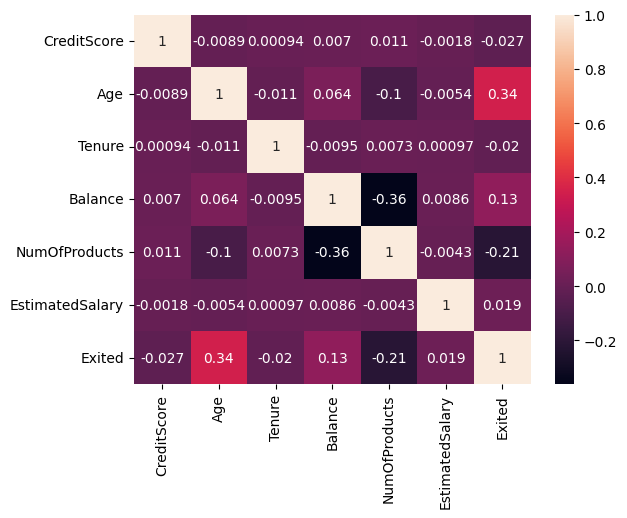

In [12]:
corrmat = num_variables.corr()
sns.heatmap(corrmat, annot=True)

<Axes: xlabel='Balance', ylabel='Age'>

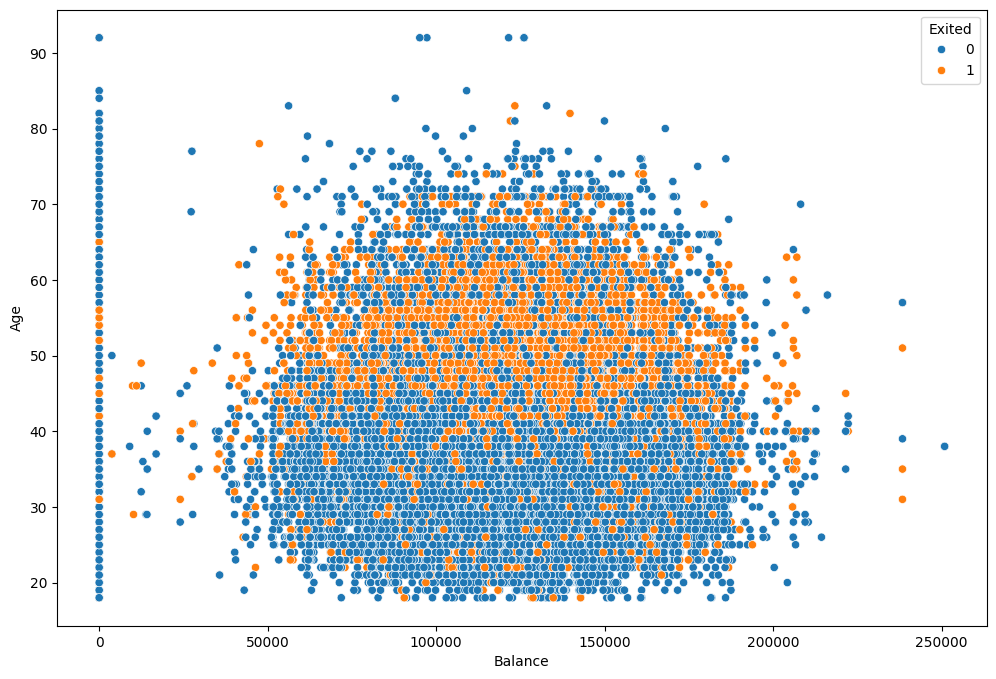

In [13]:
plt.figure(figsize=(12,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue='Exited')

<Axes: xlabel='Age', ylabel='Count'>

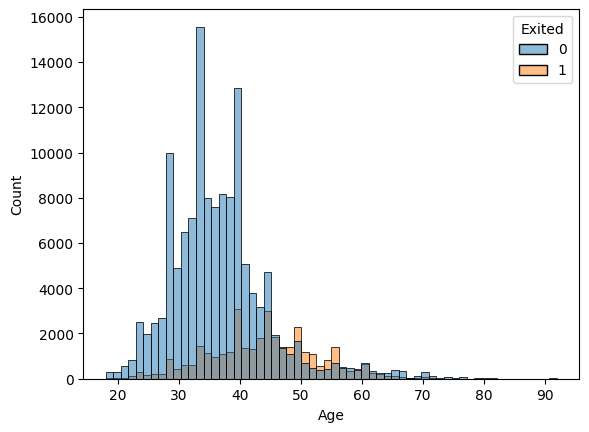

In [14]:
sns.histplot(num_variables, x='Age', hue='Exited', bins=60)

In [15]:
cat_variables = df[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']].astype({'Exited': 'O'})
cat_variables

,Geography,Gender,HasCrCard,IsActiveMember,Exited
0,France,Male,1.0,0.0,0
1,France,Male,1.0,1.0,0
2,France,Male,1.0,0.0,0
3,France,Male,1.0,1.0,0
4,Spain,Male,1.0,1.0,0
...,...,...,...,...,...
165029,Spain,Female,1.0,1.0,0
165030,France,Male,0.0,0.0,0
165031,France,Male,1.0,1.0,0
165032,Spain,Female,0.0,1.0,0


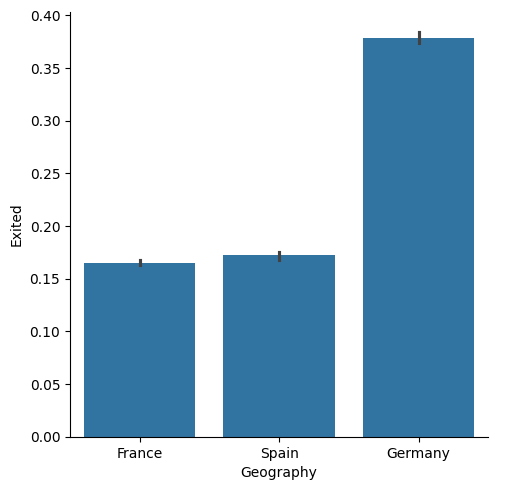

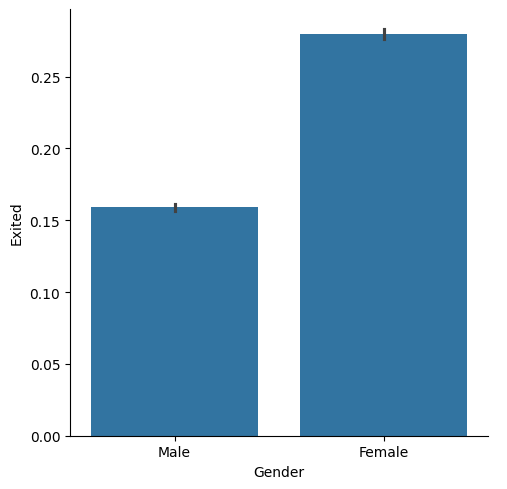

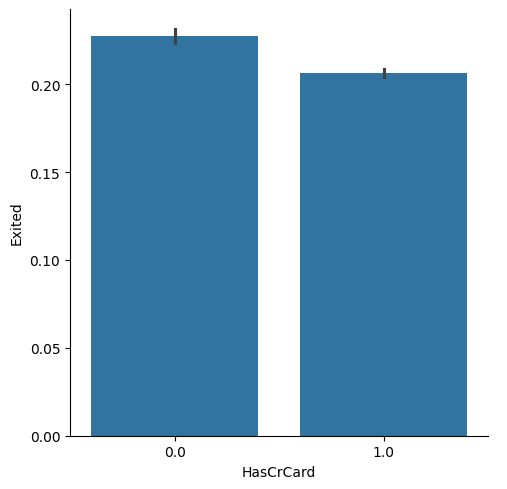

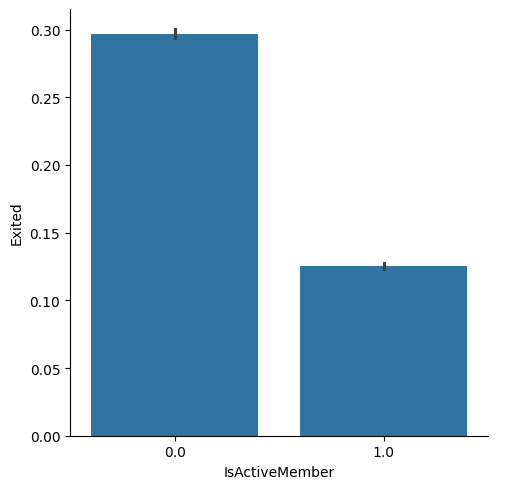

In [16]:
sns.catplot(cat_variables, kind='bar', x='Geography', y='Exited')
sns.catplot(cat_variables, kind='bar', x='Gender', y='Exited')
sns.catplot(cat_variables, kind='bar', x='HasCrCard', y='Exited')
sns.catplot(cat_variables, kind='bar', x='IsActiveMember', y='Exited')

### Models

#### Preprocessing

In [17]:
cat_variables_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_variables_cols = df.select_dtypes(['int64', 'float64']).drop(['HasCrCard', 'IsActiveMember','Exited'], axis=1).columns.to_list()

In [18]:
preprocessor = ColumnTransformer([('num', StandardScaler(), num_variables_cols),
                                   ('cat', OneHotEncoder(), cat_variables_cols)], remainder='drop')

In [19]:
df_trans = preprocessor.set_params(cat__drop='first').fit_transform(df)
df_trans

array([[ 0.14413459, -0.57807434, -0.71997339, ...,  1.        ,
         1.        ,  0.        ],
       [-0.36770579, -0.57807434, -1.43269365, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.2689737 ,  0.21135385,  1.77454751, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-1.14170832, -0.80362525, -0.00725313, ...,  1.        ,
         1.        ,  1.        ],
       [-1.27903135, -0.9164007 ,  0.70546712, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.41620652, -0.80362525, -1.43269365, ...,  1.        ,
         1.        ,  0.        ]])

In [20]:
preprocessor.get_feature_names_out()

array(['num__CreditScore', 'num__Age', 'num__Tenure', 'num__Balance',
       'num__NumOfProducts', 'num__EstimatedSalary',
       'cat__Geography_Germany', 'cat__Geography_Spain',
       'cat__Gender_Male', 'cat__HasCrCard_1.0',
       'cat__IsActiveMember_1.0'], dtype=object)

In [21]:
feature_names = num_variables_cols + preprocessor.transformers_[1][1].get_feature_names_out().tolist()

In [22]:
feature_names

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'HasCrCard_1.0',
 'IsActiveMember_1.0']

In [23]:
df_trans.shape

(165034, 11)

#### Logistic Regression

In [24]:
lr_clf = LogisticRegression(random_state=123, class_weight='balanced')

In [25]:
y_pred = cross_val_predict(lr_clf, X=df_trans, y=df['Exited'], cv=5, method='predict_proba')[:,1]
y_pred

array([0.24185885, 0.08685902, 0.3582449 , ..., 0.14214976, 0.24595299,
       0.30389065])

In [44]:
y_pred_class = cross_val_predict(lr_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
df['Exited']

0         0
1         0
2         0
3         0
4         0
         ..
165029    0
165030    0
165031    0
165032    0
165033    1
Name: Exited, Length: 165034, dtype: int64

In [28]:
roc_auc_score(df['Exited'], y_pred)

0.8187127355106241

In [29]:
lr_clf.fit(X=df_trans, y=df['Exited'])

KeyboardInterrupt: 

In [ ]:
list(zip(lr_clf.coef_[0,:], feature_names))

[(-0.061803130290010555, 'CreditScore'),
 (0.8706515240856879, 'Age'),
 (-0.042373586900327685, 'Tenure'),
 (-0.03580636331767981, 'Balance'),
 (-0.4030205958061538, 'NumOfProducts'),
 (0.035835336087908384, 'EstimatedSalary'),
 (1.0706023479717452, 'Geography_Germany'),
 (0.04236093529793653, 'Geography_Spain'),
 (-0.6710483743310656, 'Gender_Male'),
 (-0.20665777335937438, 'HasCrCard_1.0'),
 (-1.1844543772397969, 'IsActiveMember_1.0')]

In [ ]:
lr_clf.intercept_

array([0.45798933])

<Axes: xlabel='Balance', ylabel='Age'>

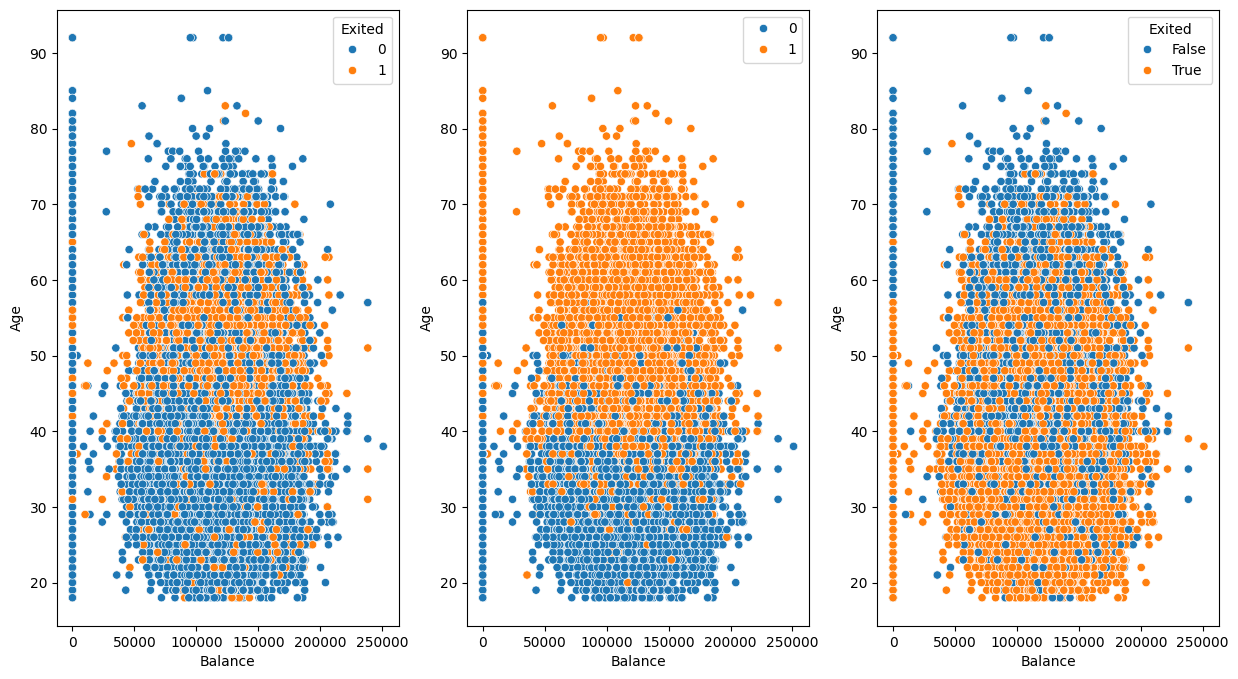

In [47]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

#### Decision Tree

In [35]:
dt_clf = DecisionTreeClassifier(random_state=123, class_weight='balanced', max_depth=5, min_samples_leaf=5)

In [40]:
y_pred = cross_val_predict(dt_clf, X=df_trans, y=df['Exited'], cv=5, method='predict_proba')[:,1]
y_pred

array([0.10235465, 0.04286545, 0.10235465, ..., 0.23494085, 0.37984466,
       0.67668224])

In [49]:
y_pred_class = cross_val_predict(dt_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
roc_auc_score(df['Exited'], y_pred)

0.8723730709048721

<Axes: xlabel='Balance', ylabel='Age'>

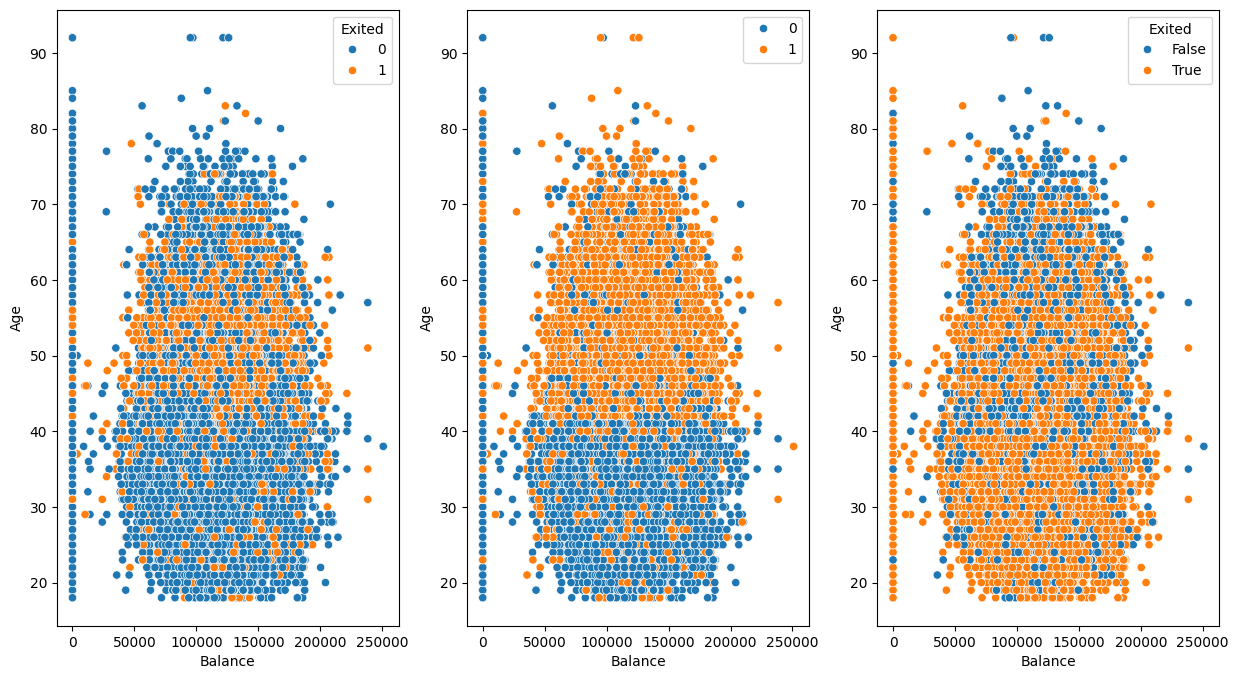

In [50]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

#### Random Forest Classifier

In [52]:
rf_clf = RandomForestClassifier(random_state=123, class_weight='balanced', max_depth=5)

In [53]:
y_pred = cross_val_predict(rf_clf, X=df_trans, y=df['Exited'], cv=5, method='predict_proba')[:,1]
y_pred

array([0.18304853, 0.10760637, 0.21053392, ..., 0.31750309, 0.36241714,
       0.46388632])

In [54]:
y_pred_class = cross_val_predict(rf_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
cross_val_score(rf_clf, X=df_trans, y=df['Exited'], cv=5, scoring='roc_auc').mean()

0.8756286403931204

In [ ]:
roc_auc_score(df['Exited'], y_pred)

0.8755756167655836

<Axes: xlabel='Balance', ylabel='Age'>

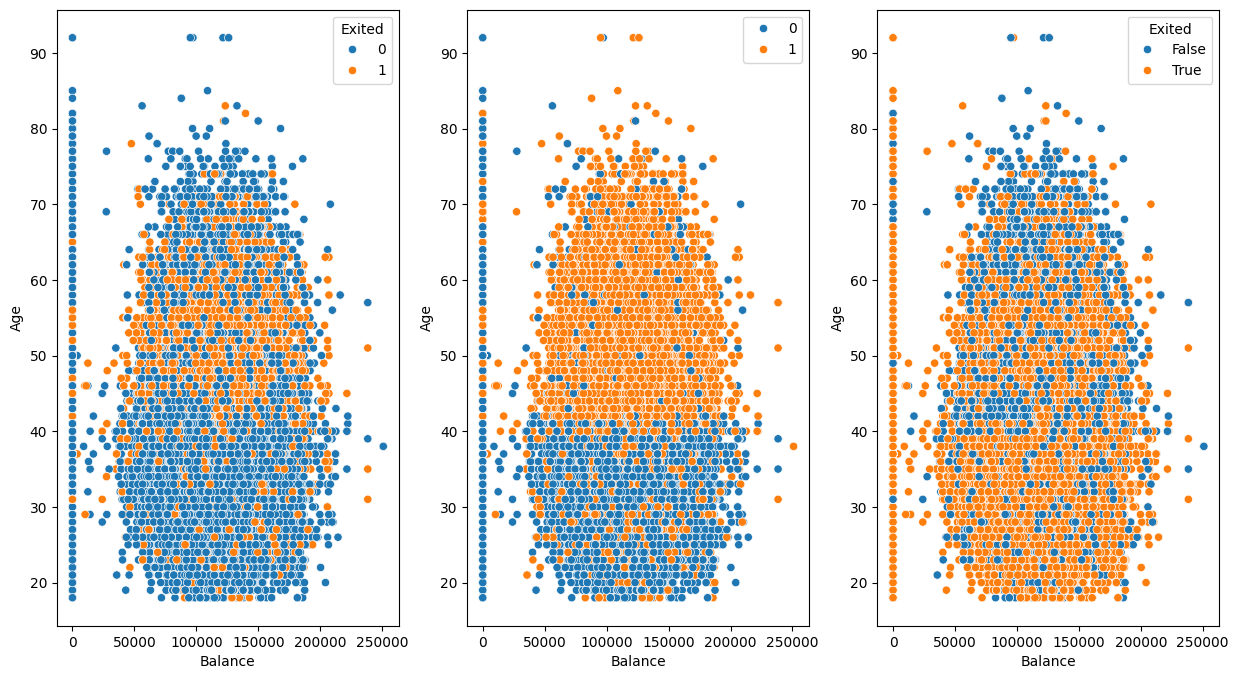

In [55]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

#### Hyperparameters optimization

In [ ]:
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.3)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.3)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create the RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        class_weight='balanced'
    )

    # Use cross-validation to evaluate the performance
    score = cross_val_score(clf, df_trans, df['Exited'], scoring='roc_auc', cv=5).mean()

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-01-05 15:27:27,955] A new study created in memory with name: no-name-f4e6a6de-7c56-4e08-b52a-2dd4077e197e
[I 2024-01-05 15:27:54,042] Trial 0 finished with value: 0.8294625028019589 and parameters: {'n_estimators': 260, 'max_depth': 16, 'min_samples_split': 0.012098165323999955, 'min_samples_leaf': 0.2077493489561343, 'max_features': 'log2'}. Best is trial 0 with value: 0.8294625028019589.
[I 2024-01-05 15:28:36,676] Trial 1 finished with value: 0.8246271730900165 and parameters: {'n_estimators': 403, 'max_depth': 29, 'min_samples_split': 0.19548665641049598, 'min_samples_leaf': 0.23492530066816295, 'max_features': 'log2'}. Best is trial 0 with value: 0.8294625028019589.
[I 2024-01-05 15:29:43,967] Trial 2 finished with value: 0.8420631924143345 and parameters: {'n_estimators': 430, 'max_depth': 14, 'min_samples_split': 0.08185039104179267, 'min_samples_leaf': 0.09816252083609946, 'max_features': 'log2'}. Best is trial 2 with value: 0.8420631924143345.
[I 2024-01-05 15:30:36,51

In [ ]:
study.best_params

{'n_estimators': 155,
 'max_depth': 31,
 'min_samples_split': 0.010295743725836934,
 'min_samples_leaf': 0.010012320708820526,
 'max_features': 'log2'}

In [ ]:
study.best_trial

FrozenTrial(number=492, state=TrialState.COMPLETE, values=[0.8643607990539763], datetime_start=datetime.datetime(2024, 1, 5, 21, 49, 4, 418948), datetime_complete=datetime.datetime(2024, 1, 5, 21, 49, 47, 539919), params={'n_estimators': 155, 'max_depth': 31, 'min_samples_split': 0.010295743725836934, 'min_samples_leaf': 0.010012320708820526, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'min_samples_leaf': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None))}, trial_id=492, value=None)

In [ ]:
rf_clf_optuna = RandomForestClassifier(random_state=42, n_estimators=155, max_depth=31, min_samples_leaf=0.010012320708820526, min_samples_split=0.010295743725836934, max_features='log2')

### Submission

In [ ]:
df_test = pd.read_csv(os.path.join('datasets', 'test.csv'))
df_test_id = df_test['id']
df_test.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)
df_test = preprocessor.set_params(cat__drop='first').fit_transform(df_test)

In [ ]:
y_pred = rf_clf.fit(X=df_trans, y=df['Exited']).predict_proba(df_test)[:,1]
y_pred

array([0.15644482, 0.8454572 , 0.23153561, ..., 0.18206213, 0.39495687,
       0.52733317])

In [ ]:
submission = pd.DataFrame(data={'id': df_test_id, 'Exited': y_pred})
submission.head()

,id,Exited
0,165034,0.156445
1,165035,0.845457
2,165036,0.231536
3,165037,0.492847
4,165038,0.609587


In [ ]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [ ]:
submission.to_csv(os.path.join('submissions','Random Forest Classifier without Optuna.csv'), index=False)